<a name='introduction'></a>
# Проект "Отток клиентов"

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры: > 0.59.

Дополнительно измеряется *AUC-ROC* и сравнивается с значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Введение**:

Предоставлена база данных с клиентами банка и различными данными о них. Целью данного проекта является выявление наиболее подходящей модели машинного обучения, которая бы наилучшим образом предсказала, уйдет клиент из банка в ближайшее время или же останется.

**План проекта**: 
 1. [Подготовка данных](#data_preparation)
 2. [Исследование задачи](#task_research) (рассмотрение моделей без учета дисбаланса классов)
 3. [Борьба с дисбалансом](#fighting_imbalance) (применение методов с целью устранения дисбаланса класса и рассмотрение показателя f1_score)
 4. [Тестирование моделей](#model_testing) (на тестовой уже выборке)

<a name="data_preparation"></a>
## 1. Подготовка данных

Первоначально рассмотрим пропущенные значения, если таковые имеются, а далее перейдем к реорганизации таблицы для того, чтобы ее можно было бы максимально эффективно использовать при построении различных моделей машинного обучения.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

clients_df = pd.read_csv("Churn.csv")

In [2]:
clients_df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

NaN-значения в категории "Tenure" говорят скорее о том, что человек является клиентом банка относительно непродолжительное время и не прошло даже и года. Ввиду этого, заполним пропущенные значения на "0.0".

In [3]:
clients_df.loc[clients_df['Tenure'].isna(), 'Tenure'] = 0.0

In [4]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Разобравшись с пропущенными значениями, перейдем к реорганизации категорий таблицы клиентов.

Важно отметить, что некоторые столбцы не могут играть никакой роли для алгоритмов машинного обучения, поскольку отсутствует какая-либо связь между значением столбца и другими данными. К таким можно отнести следующие столбцы: 'RowNumber' (индекс строки в данных), 'CustomerId' (уникальный идентификатор клиента) и 'Surname' (фамилия). Ввиду этого, удалим данные столбцы из базы данных ввиду отсутствия необходимости в их использовании для обучения модели машинного обучения.

In [5]:
clients_df = clients_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Для дальнейшего обучения будем использовать OHE (One-Hot Encoding) во всех моделях (поскольку OHE можно применять при обучении всех моделей)

In [6]:
clients_df = pd.get_dummies(clients_df, drop_first=True)

clients_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


<a name="task_research"></a>
## 2. Исследование задачи
[Вернуться во Введение](#introduction)

Изучим баланс классов, посмотрим на поведение моделей и результаты их работы без учета без дисбаланса

In [7]:
X = clients_df.drop(['Exited'], axis=1)
y = clients_df['Exited']

In [8]:
# Разделение на тренировочные, валидационные и тестовые выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=12345,
    stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid,
    y_valid,
    random_state=12345,
    test_size=0.5,
    stratify=y_valid
)

In [9]:
# Количество объектов по классам
print(X[y == 0].count().sum())
print(X[y == 1].count().sum())

87593
22407


In [10]:
# Осуществим масштабирование признаков
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

Далее найдем оптимальные параметры для каждой из модели.

**DecisionTreeClassifier**

In [11]:
model_1 = DecisionTreeClassifier(random_state=12345)

params = {'max_depth': range(2, 21, 2)}

grid_1 = GridSearchCV(model_1, params)
grid_1.fit(X_train, y_train)

print(grid_1.best_estimator_)

DecisionTreeClassifier(max_depth=6, random_state=12345)


In [12]:
model_1 = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_1.fit(X_train, y_train)

predicted_valid = model_1.predict(X_valid)
print("f1_score:", f1_score(y_valid, predicted_valid))

f1_score: 0.608272506082725


**RandomForestClassifier**

In [15]:
model_2 = RandomForestClassifier(random_state=12345)

params = {'max_depth': range(2, 16, 2), 'n_estimators': range(50, 250, 50)}

grid_2 = GridSearchCV(model_2, params)
grid_2.fit(X_train, y_train)

print(grid_2.best_estimator_)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=12345)


In [16]:
model_2 = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200)
model_2.fit(X_train, y_train)
predicted_valid = model_2.predict(X_valid)
print("f1_score:", f1_score(y_valid, predicted_valid))

f1_score: 0.585


**LogisticRegression**

In [17]:
model_3 = LogisticRegression(random_state=12345)

params = {'max_iter': range(100, 1001, 100)}

grid_3 = GridSearchCV(model_3, params)
grid_3.fit(X_train, y_train)

print(grid_3.best_estimator_)

LogisticRegression(random_state=12345)


In [18]:
model_3 = LogisticRegression(random_state=12345)
model_3.fit(X_train, y_train)

predicted_valid = model_3.predict(X_valid)
print("f1_score:", f1_score(y_valid, predicted_valid))

f1_score: 0.29341317365269465


**Промежуточный вывод**:

Наивысший значение по показателю f1_score на валидационной выборке демонстрирует DecisionTreeClassifier с максимальной глубиной дерева равной 6. Результат f1_score модели составляет 0.608. Наименьшее значение при LogisticRegression - 0.088, поскольку не учитывается дисбаланс классов. 

<a name="fighting_imbalance"></a>
## 3. Борьба с дисбалансом
[Вернуться во Введение](#introduction)

Посмотрим на значение f1_score при учите дисбаланса классов в каждой из рассматриваемой модели.

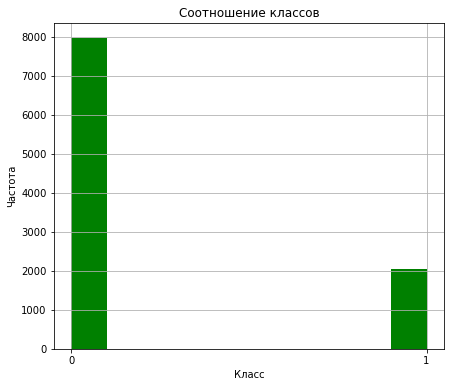

In [19]:
y.plot(
    x=y,
    kind='hist',
    color='green',
    grid=True,
    title='Соотношение классов',
    figsize=[7, 6]
)

plt.xlabel('Класс')
plt.ylabel('Частота')
plt.xticks([0, 1])
plt.show()

Вероятно, для некоторых моделей понадобится использование большего количество объектов класса "1", чтобы они лучше обучились. Ввиду этого, посмотрим нам изменение метрики f1_score при использовании методов как upsampling, так downsampling.

**DecisionTreeClassifier**

In [37]:
model_1 = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced')
model_1.fit(X_train, y_train)

predicted_valid = model_1.predict(X_valid)
print("f1_score:", f1_score(y_valid, predicted_valid))

f1_score: 0.579172610556348


Посмотрим на влиения **upsampling** и **downsampling** на значение метрики f1_score.

In [38]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_upsampled = pd.concat([X_zeros.sample(frac=fraction)] + [X_ones])
    y_upsampled = pd.concat([y_zeros.sample(frac=fraction)] + [y_ones])
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

In [39]:
# Осуществим увеличение выборки
best_f1_score = 0
best_rep_dt = 0

for rep in range(1, 10, 1):
    X_u, y_u = upsample(X_train, y_train, rep)

    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=6)
    model_1.fit(X_u, y_u)

    predicted_valid = model_1.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_rep_dt = rep

print(f"best_f1_score: {best_f1_score}, best_repeat: {best_rep_dt}")

best_f1_score: 0.608272506082725, best_repeat: 1


In [40]:
# Осуществим уменьшение выборки
best_f1_score = 0
best_frac_dt = 0

for fraction in range(2, 21):
    X_u, y_u = downsample(X_train, y_train, fraction * 0.05)

    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=6)
    model_1.fit(X_u, y_u)

    predicted_valid = model_1.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_frac_dt = fraction * 0.05

print(f"best_f1_score: {best_f1_score}, best_frac: {best_frac_dt}")


best_f1_score: 0.6190476190476191, best_frac: 0.55


С downsampling всегда получается разный результат f1_score, но, на основе эмпирических тестов, значение f1_score почти всегда выше значений при использовании upsampling. Ввиду этого предпочтительней использовать downsampling при обучении модели DesicionTreeClassifier.

**RandomForestClassifier**

In [41]:
model_2 = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200, class_weight='balanced')
model_2.fit(X_train, y_train)

predicted_valid = model_2.predict(X_valid)
score_f1 = f1_score(y_valid, predicted_valid)

print(f"f1_score: {score_f1}")

f1_score: 0.640625


In [42]:
best_f1_score = 0
best_rep_rf = 0

for rep in range(1, 10, 1):
    X_u, y_u = upsample(X_train, y_train, rep)

    model_2 = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200)
    model_2.fit(X_u, y_u)

    predicted_valid = model_2.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_rep_rf = rep


print(f"best_f1_score: {best_f1_score}, best_repeat: {best_rep_rf}")

best_f1_score: 0.6524271844660194, best_repeat: 3


In [43]:
best_f1_score = 0
best_frac_rf = 0

for fraction in range(2, 21):
    X_u, y_u = downsample(X_train, y_train, fraction * 0.05)

    model_2 = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200)
    model_2.fit(X_u, y_u)

    predicted_valid = model_2.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_frac_rf = fraction * 0.05

print(f"best_f1_score: {best_f1_score}, best_frac: {best_frac_rf}")

best_f1_score: 0.6533333333333333, best_frac: 0.30000000000000004


В целом показатели метрики f1_score при осуществлении upsampling и downsampling для модели RandomForestClassifier одинаково высоки и выше требуемых 0.59. Важно отметить, что существенную разницу играет и значение 'balanced' атрибута 'class_weight, с помощью которого на валидационной выборке значение f1_score достигло 0.642 (при том, что без балансировка классов данный показатель составлял 0.585). Тем не менее, наивысшие показатели приходятся именно на использование **upsampling** и **downsampling**.

**Логистическая регрессия**

In [44]:
# Рассмотрим значение F1-меры при использовании логистической регрессии
model_3 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_3.fit(X_train, y_train)

predicted_valid = model_3.predict(X_valid)

print(f1_score(y_valid, predicted_valid))

0.5205479452054794


In [45]:
# Осуществим увеличение выборки
best_f1_score = 0
best_rep_lr = 0

for rep in range(1, 10, 1):
    X_u, y_u = upsample(X_train, y_train, rep)

    model_3 = LogisticRegression(random_state=12345)
    model_3.fit(X_u, y_u)

    predicted_valid = model_3.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_rep_lr = rep

print(f"best_f1_score: {best_f1_score}, best_rep: {best_rep_lr}")

best_f1_score: 0.5236167341430499, best_rep: 4


In [46]:
# Осуществим уменьшение выборки
best_f1_score = 0
best_frac_lr = 0

for fraction in range(2, 21):
    X_u, y_u = downsample(X_train, y_train, fraction * 0.05)

    model_3 = LogisticRegression(random_state=12345)
    model_3.fit(X_u, y_u)

    predicted_valid = model_3.predict(X_valid)
    score = f1_score(y_valid, predicted_valid)
    if score > best_f1_score:
        best_f1_score = score
        best_frac_lr = fraction * 0.05

print(f"best_f1_score: {best_f1_score}, best_frac: {best_frac_lr}")

best_f1_score: 0.5380875202593193, best_frac: 0.35000000000000003


Значения метрики f1_score при использовании модели LogisticRegression крайне низки (<= 0.5). И не подходят под условие задачи (f1_score => 0.59). Более того наибольшее значение метрики f1_score получается при использовании значения 'balanced' атрибута 'class_weight', а не upsampling и downsampling, как было в моделях DecisionTreeClassifier и RandomForestClassifier.

**Промежуточный вывод**:

Наивысшие значения метрики f1_score демонстрируют модели DecisionTreeClassifier и RandomForestClassifier. По крайне мере на валидационной выборке их значения превышают необходимые 0.59. LogisticRegression, даже с учетом дисбаланса классов, показывает не столь высокое значение f1_score - около 0.46, что явно ниже порогового значения в 0.59. Вряд ли значение на тестовой выборке будет выше, однако рассмотрим это далее.

Более того, DecisionTreeClassifier наилучшим образом обучается при уменьшении выборки (downsampling). Однако, ввиду того, что значение может варьироваться при повторных итерациях, долю, при которой модель демонстрирует наивысшее значение f1_score метрики сохраним в отдельную переменную и будем использовать в дальнейшем.

При RandomForestClassifier применение upsampling или downsampling действительно незначительно, но повышение значение f1_score, однако разница между двумя методами борьбы с дисбалансом минимальна. При тестировании модели будем использовать upsampling, как первый из вариантов.

<a name="model_testing"></a>
## 4. Тестирование моделей
[Вернуться во Введение](#introduction)

Осуществим тестирование моделей на тестовых выборках. Помимо f1_score рассмотрим также и метрику AUC_ROC с помощью roc_auc_score из библиотеки sklearn.

**DecisionTreeClassifier**

In [51]:
# Уменьшение выборки и получение значения f1-меры для DecisionTreeClassifier
X_u, y_u = downsample(X_train, y_train, best_frac_dt)

model_1 = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_1.fit(X_u, y_u)
predicted_test = model_1.predict(X_test)

score_f1 = f1_score(y_test, predicted_test)
score_auc_roc = roc_auc_score(y_test, predicted_test)

print(f"f1_score = {score_f1}, auc_roc = {score_auc_roc}")

f1_score = 0.5633270321361059, auc_roc = 0.7300540745659805


**RandomForestClassifier**

In [52]:
# Увеличение выборки и получение значения f1-меры для RandomForestClassifier
X_u, y_u = upsample(X_train, y_train, best_rep_rf)

model_2 = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=200)
model_2.fit(X_u, y_u)
predicted_test = model_2.predict(X_test)

score_f1 = f1_score(y_test, predicted_test)
score_auc_roc = roc_auc_score(y_test, predicted_test)

print(f"f1_score = {score_f1}, auc_roc = {score_auc_roc}")

f1_score = 0.626641651031895, auc_roc = 0.7725152578819214


**LogisticRegression**

In [49]:
# Получения значений F1-меры для LogisticRegression
model_3 = LogisticRegression(random_state=12345, class_weight='balanced')
model_3.fit(X_train, y_train)
predicted_test = model_3.predict(X_test)

score_f1 = f1_score(y_test, predicted_test)
score_auc_roc = roc_auc_score(y_test, predicted_test)

print(f"f1_score = {score_f1}, auc_roc = {score_auc_roc}")

f1_score = 0.4786795048143054, auc_roc = 0.6924192834329445


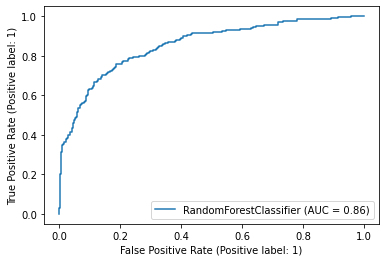

In [50]:
# Визуализация значения ROC-AUC с лучшей моделью - RandomForestClassifier
roc_plot = plot_roc_curve(model_2, X_test, y_test)
plt.show()

**Вывод**

Получилось достичь результат f1_score больше 0.59. Единственная модель, которая на тестовой выборке продемонстрировала данный результат - это RandomForestClassifier со следующими параметрами: максимальная глубина дерева - 10, количество деревьев - 200. В дополнение к этому используется метод увеличения выборки (upsampling) для лучшего обучения модели на тренировочной выборке. Используя упомянутые параметры, модель достигла значения метрики f1_score в 0.627, а auc_roc = 0.77 (к слову чем ближе auc_roc к единице, тем лучше модель). 

**Рекомендации**:
Следовательно, для наиболее точного определения, уйдет клиент или останется, рекомендуется использовать случайны лес (RandomForestClassifier). Поскольку и f1_score выше необходимых 0.59, и auc_roc ближе к единице, чем к 0.5 (абсолютно случайной модели).